# Cortical Distribution of Temporal Receptive Windows in ECoG during Story Listening

Listening to stories requires the brain to process linguistic information over multiple time-scales to understand the narrative, from phonemes to words, sentences, and paragraphs. Different brain areas may have different processing time-scales—temporal receptive windows (TRWs)—over which they accumulate information; for example, low-level auditory areas operate over short time-scales, while high-level cortical areas integrate information over longer periods. In this study, we quantify temporal receptive fields across the cortical processing hierarchy during naturalistic story listening. We analyzed electrocorticography (ECoG) signals from 160 electrodes across N = 10 subjects listening to a 30-minute spoken narrative (a podcast episode). To quantify TRWs, we estimated the autocorrelation function (ACF) at each electrode, which measures the similarity of a signal with a delayed version of itself over varying time lags. The width of the autocorrelation function (ACW) indicates the TRW length, with wider ACWs suggesting longer TRWs. In line with [previous work](https://pubmed.ncbi.nlm.nih.gov/23083743/), we find that ACWs vary across cortical electrodes during speech comprehension, suggesting that different cortical areas encode features of language evolving over varying time-scales.

In [236]:
import os
import scipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import mne
import pandas as pd
import pandasql as ps
from nilearn import plotting

## Read In Subject from Drive

In [133]:
df = pd.read_csv('podcast_MNIcoor_masterlist.csv')
df1 = pd.read_csv('podcast.csv')
df.head()

,subject_number,electrode_name,x,y,z,code,num1,num2,num3,num4,...,percentage,region,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,798,G55,-72.000000,-30.000000,9.000000,G,0,1,0,0,...,100.00%,bankssts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,798,G56,-70.000000,-37.333333,17.333333,G,1,1,1,1,...,100.00%,bankssts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,798,G63,-71.333333,-36.000000,2.666667,G,0,1,0,0,...,75.56%,bankssts,24.44%,cMTG,NaN,NaN,NaN,NaN,NaN,NaN
3,662,EEGLF_04REF,-50.000000,38.000000,23.000000,S,0,0,0,0,...,100.00%,caudalmiddlefrontal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,662,EEGLF_05REF,-46.000000,33.500000,36.000000,S,0,0,0,0,...,100.00%,caudalmiddlefrontal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
# drop duplicate columns
# Use pandasql to select unique columns
# Create a unique DataFrame without duplicate columns
unique_columns = new_df.loc[:, ~new_df.columns.duplicated()]

# Use pandasql to work with unique columns
query = "SELECT * FROM unique_columns"

# Execute the query
fin_df = ps.sqldf(query)
fin_df.head()

,subject_number,electrode_name,x,y,z,region,subject_electrode,elec
0,798,G56,-70.000000,-37.333333,17.333333,bankssts,NY798_111_Part1_conversation1_G56,56
1,743,G3,-53.000000,19.000000,46.000000,caudalmiddlefrontal,NY743_111_Part1_conversation1_G3,3
2,743,G11,-59.000000,17.000000,38.000000,caudalmiddlefrontal,NY743_111_Part1_conversation1_G11,11
3,798,G5,-49.333333,21.000000,47.000000,caudalmiddlefrontal,NY798_111_Part1_conversation1_G5,5
4,743,G64,-68.666667,-51.333333,4.000000,cMTG,NY743_111_Part1_conversation1_G64,64


In [169]:
fin_df.shape

(160, 8)

In [177]:
# Sort the DataFrame by subject_number
df_sorted = fin_df.sort_values(by='subject_number')

# Print the rows where subject_number is 717
# result = df_sorted[df_sorted['subject_number'] == 717]
df_sorted.head(10)

,subject_number,electrode_name,x,y,z,region,subject_electrode,elec
29,662,EEGPO_02REF,-62.000000,-58.000000,0.500000,mMTG,NY662_111_Part1_conversation1_EEGPO_02REF,2
31,717,LGA47,-74.000000,-25.000000,-3.000000,mMTG,NY717_111_Part1_conversation1_LGA47,47
32,717,LGB119,-72.000000,-8.666667,-5.333333,mMTG,NY717_111_Part1_conversation1_LGB119,119
33,717,LGB126,-74.000000,-20.000000,-5.000000,mMTG,NY717_111_Part1_conversation1_LGB126,126
136,717,LGB71,-58.000000,36.000000,21.000000,rostralmiddlefrontal,NY717_111_Part1_conversation1_LGB71,71
151,717,LGA32,-71.000000,-27.000000,22.000000,supramarginal,NY717_111_Part1_conversation1_LGA32,32
39,717,LGA37,-69.333333,-0.666667,-3.000000,mSTG,NY717_111_Part1_conversation1_LGA37,37
40,717,LGA38,-72.000000,-11.333333,2.666667,mSTG,NY717_111_Part1_conversation1_LGA38,38
41,717,LGB112,-68.000000,2.666667,-5.333333,mSTG,NY717_111_Part1_conversation1_LGB112,112
42,717,LGB113,-72.000000,-6.000000,0.000000,mSTG,NY717_111_Part1_conversation1_LGB113,113


In [184]:
df_sorted.shape

(160, 8)

In [187]:
all_ecog_data = []
all_ch_names = []
all_ch_pos = {}

# Iterate through unique subject numbers
for subject in df_sorted['subject_number'].unique():
    # Get electrodes for the current subject
    subject_df = df_sorted[df_sorted['subject_number'] == subject]
    electrodes = subject_df['elec'].tolist()
    
    ecog_data = []

    for elec in electrodes:
        # Get the corresponding electrode row
        electrode_row = subject_df[subject_df['elec'] == elec]
        electrode_name = electrode_row['electrode_name'].values[0]
        
        # Building the filename
        filename = f"/Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY{subject}_111_Part1_conversation1/raw/NY{subject}_111_Part1_conversation1_electrode_raw_file_{elec}.mat"
        mat = scipy.io.loadmat(filename)['electrode_data']
        ecog_data.append(mat[0])

        # Create a unique key combining subject and electrode name
        unique_key = f"NY{subject}_{electrode_name}"
        
        # Add the channel position
        all_ch_pos[unique_key] = (electrode_row['x'].values[0], 
                                      electrode_row['y'].values[0], 
                                      electrode_row['z'].values[0])
        all_ch_names.append(unique_key)

    all_ecog_data.extend(ecog_data)

all_ecog_data = np.vstack(all_ecog_data)

# Print the shape of the data for verification
print(all_ecog_data.shape)  # Should be (number_of_electrodes, 921601)


sfreq = 512
info = mne.create_info(ch_names=all_ch_names, sfreq=sfreq, ch_types=['ecog'] * len(all_ch_names))


montage = mne.channels.make_dig_montage(ch_pos=all_ch_pos, coord_frame='mri')

# Double checking all channels are present in montage
missing_channels = set(all_ch_names) - set(montage.ch_names)
if missing_channels:
    raise ValueError(f"Channels missing from montage: {missing_channels}")

info.set_montage(montage)


raw = mne.io.RawArray(all_ecog_data, info)

(160, 921601)
Creating RawArray with float64 data, n_channels=160, n_times=921601
    Range : 0 ... 921600 =      0.000 ...  1800.000 secs
Ready.


/var/folders/_7/61vbt98120v7tjjx9b62g2ph0000gn/T/ipykernel_29135/2287083473.py:51: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(montage)


## Downsample

In [563]:
new_sfreq = 400
raw_resampled = raw.copy().resample(new_sfreq)

In [349]:
len(raw_resampled) / new_sfreq

1800.0025

In [190]:
len(raw) / 512

1800.001953125

In [191]:
data = raw_resampled.get_data()
data.shape

(160, 720001)

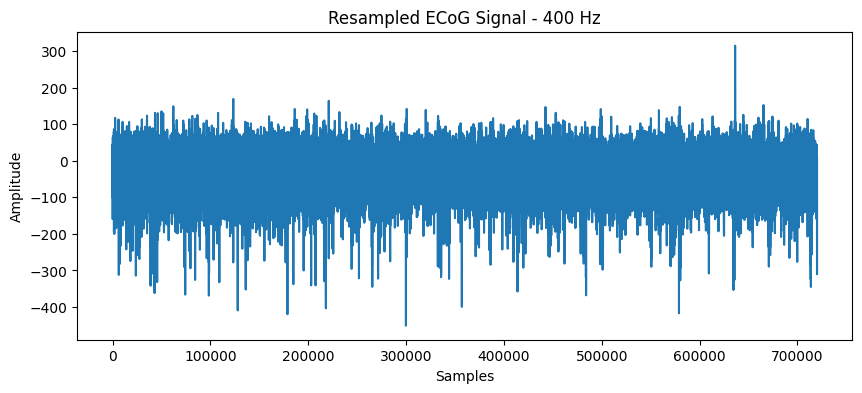

In [192]:
# plot resampled signal
plt.figure(figsize=(10, 4))
plt.plot(data[0])
plt.title('Resampled ECoG Signal - 400 Hz')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

# Power spectrum 

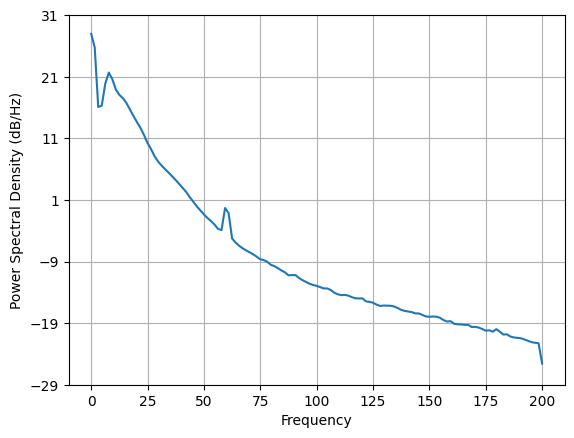

In [193]:
Pxx, freqs = plt.psd(data[0], Fs=raw_resampled.info['sfreq'])
plt.show()

# Notch Filtering

Removing power noise frequency bands 60, 120, & 180.

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 2641 samples (6.603 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.1s


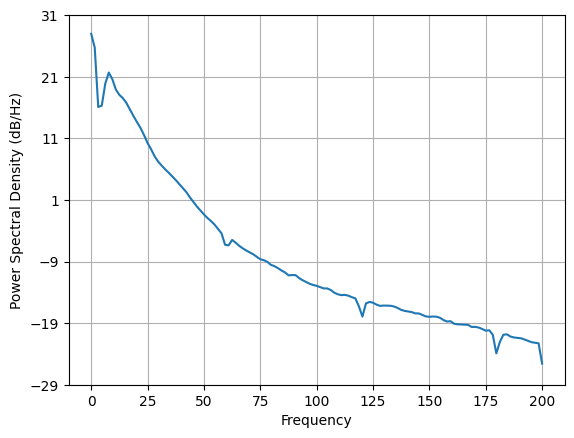

In [564]:
freqs = [60,120,180]

ecog_no_noise = raw_resampled.notch_filter(freqs)

Pxx, freqs = plt.psd(ecog_no_noise.get_data()[0], Fs=raw_resampled.info['sfreq']) 

plt.show()

Effective window size : 5.120 (s)
Plotting power spectral density (dB=True).


/var/folders/_7/61vbt98120v7tjjx9b62g2ph0000gn/T/ipykernel_29135/1791565242.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  ecog_no_noise.compute_psd().plot(axes=ax)


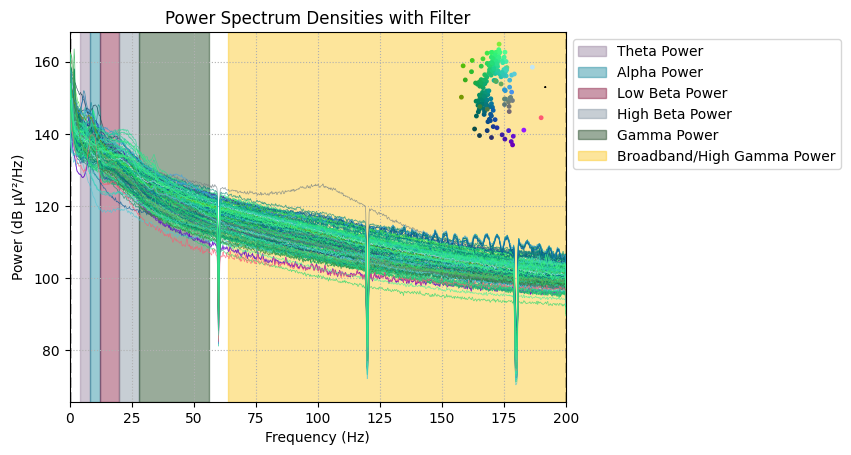

In [562]:
fig, ax = plt.subplots()
ecog_no_noise.compute_psd().plot(axes=ax)
ax.axvspan(4, 8, alpha=0.4, color='#887191', label='Theta Power')
ax.axvspan(8, 12, alpha=0.4, color='#017b92', label='Alpha Power')
ax.axvspan(12, 20, alpha=0.4, color='#7b002c', label='Low Beta Power')
ax.axvspan(20, 28, alpha=0.4, color='#738595', label='High Beta Power')
ax.axvspan(28, 56, alpha=0.4, color='#002d04', label='Gamma Power')
ax.axvspan(64, 200, alpha=0.4, color='#fcc006', label='Broadband/High Gamma Power')
ax.set_title('Power Spectrum Densities with Filter')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('power-spectrums.svg')
plt.show()

## Extracting High Gamma Frequency Bands (64-200 Hz)

In [347]:
raw.get_data().shape

(160, 921601)

In [565]:
ecog_filtered = ecog_no_noise.filter(l_freq=64, 
                                     h_freq=199, 
                                     method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 64 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 64.00, 199.00 Hz: -6.02, -6.02 dB



In [352]:
ecog_filtered.get_data().shape

(160, 720001)

In [36]:
type(ecog_filtered)

mne.io.array.array.RawArray

In [566]:
# create copies since .crop is permanent
ecog_filter1 = ecog_filtered.copy()
ecog_filter2 = ecog_filtered.copy()
ecog_filter2.get_data().shape

(160, 720001)

In [234]:
ecog_filtered.crop?

Signature: ecog_filtered.crop(tmin=0.0, tmax=None, include_tmax=True, *, verbose=None)
Docstring:
Crop raw data file.

Limit the data from the raw file to go between specific times. Note
that the new ``tmin`` is assumed to be ``t=0`` for all subsequently
called functions (e.g., :meth:`~mne.io.Raw.time_as_index`, or
:class:`~mne.Epochs`). New :term:`first_samp` and :term:`last_samp`
are set accordingly.

Thus function operates in-place on the instance.
Use :meth:`mne.io.Raw.copy` if operation on a copy is desired.

Parameters
----------

tmin : float
    Start time of the raw data to use in seconds (must be >= 0).

tmax : float
    End time of the raw data to use in seconds (cannot exceed data duration).

include_tmax : bool
    If True (default), include tmax. If False, exclude tmax (similar to how
    Python indexing typically works).

    .. versionadded:: 0.19

verbose : bool | str | int | None
    Control verbosity of the logging output. If ``None``, use the default
    verbosity l

## Create 10 Minute Segments from Signal

In [567]:
first_raw = ecog_filtered.crop(tmin=0, tmax=599) # first 10 mins
second_raw = ecog_filter1.crop(tmin=600, tmax=1199) # second 10 mins
third_raw = ecog_filter2.crop(tmin=1200, tmax=1799) # last 10 mins
first_raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,160 points
Good channels,160 ECoG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,400.00 Hz
Highpass,64.00 Hz
Lowpass,199.00 Hz


In [568]:
# Array split to 20 secs
first_data = np.array_split(first_raw.get_data(), 30, axis=1)
print('Number of arrays [first 10 min segment]:', len(first_data))
# [e.shape for e in first_data]
second_data = np.array_split(second_raw.get_data(), 30, axis=1)
print('Number of arrays [second 10 min segment]:', len(second_data))
# [r.shape for r in second_data]
third_data = np.array_split(third_raw.get_data(), 30, axis=1)
print('Number of arrays [last 10 min segment]:', len(third_data))
# [t.shape for t in third_data]

Number of arrays [first 10 min segment]: 30
Number of arrays [second 10 min segment]: 30
Number of arrays [last 10 min segment]: 30


In [204]:
[e.shape for e in first_data]

[(160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7986),
 (160, 7986),
 (160, 7986),
 (160, 7986),
 (160, 7986),
 (160, 7986),
 (160, 7986),
 (160, 7986),
 (160, 7986)]

## Autocorrelation Function

In [200]:
from scipy.signal import correlate, correlation_lags

def auto_corr(
    x: np.ndarray,
    y: np.ndarray,
    mode="same",
    method="fft",
    norm=True,
    maxlags=None
):
    """General function to compute auto correlation using scipy

    This function will center the data and normalize it by default.
    """

    # Center
    x = x - x.mean()
    y = y - y.mean()

    # Correlate
    corr = correlate(x, y, mode=mode, method=method)
    lags = correlation_lags(x.size, y.size, mode=mode)

    if norm:
        corr /= np.sqrt(np.dot(x, x) * np.dot(y, y))

    if maxlags is not None:
        middle = (lags == 0).nonzero()[0].item()
        lags = np.arange(-maxlags, maxlags + 1)
        corr = corr[middle - maxlags : middle + maxlags + 1]

    return corr, lags

## Autocorrelation Width Function

In [219]:
# Gaussian dist of values for better FWHM plotting of points
from scipy.interpolate import UnivariateSpline

# create spline function
def spline_graph(t, r):
    spline = UnivariateSpline(t, r-np.max(r)/2, s=0)
    roots = spline.roots()
    if len(roots) > 2:
        half_root_indx = len(roots) // 2
        r2 = roots[half_root_indx]
        r1 = roots[half_root_indx - 1]
    elif len(roots)==2:
        r1, r2 = spline.roots() # find the roots
    return r1, r2

Original freq: 512 Hz (samples / sec)<br>
1 s = 512 samples<br>
1.953125 ms = 1 sample<br>

Sample freq: 400 Hz<br>
1 s = 400 samples<br>
2.5 ms = 1 sample

## Fixing Spline Graph Function

Ran into a situation where doing UnivariateSpline returned more than two roots, which was too much to unpack for r1,r2. The code below shows a case where 6 roots were returned so to handle this, took the length of the roots array and divided by half. Whichever value is in the last index is the r2 and r1 is half index - 1. From there the function can continue to return r2 and r1 for further processing. [Source](https://stackoverflow.com/questions/10582795/finding-the-full-width-half-maximum-of-a-peak) for spline function.

[-4.30305105 -3.9767945  -0.6570042   0.6570042   3.9767945   4.30305105]


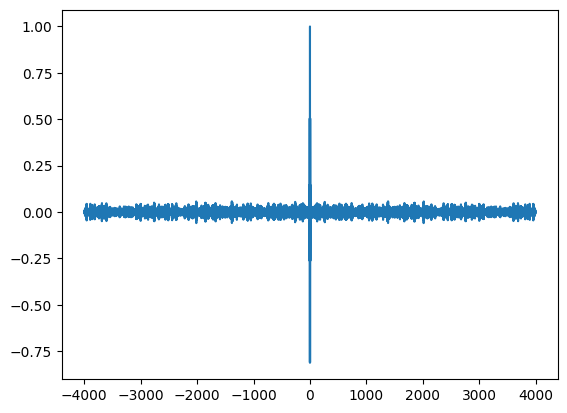

In [218]:
tmp = first_data[0][40]
corr, lags = auto_corr(tmp, tmp)
print(UnivariateSpline(lags, corr-np.max(corr)/2, s=0).roots())
plt.plot(lags, corr);
plt.show()


## Calculating ACW for Each of Three Chunks and Their Mean

In [441]:
from collections import defaultdict

In [569]:
# ZZ suggestion:

ACW_first = np.zeros((len(data), len(first_data)))
# need to create ACW to fit each 10 min segment
# create more ACW vars then concat before mean averaging?
first_corr_results = defaultdict(list)
first_lag_results = defaultdict(list)

# split_data = [ (n_elec x samples) ]

# for each chunk in the 10-min
for i, chunk in enumerate(first_data):
    # chunk.shape = n_electrodes x time

    # for each electrode
    for j, electrode_chunk in enumerate(chunk):
        # print(i, j, chunk.shape, electrode_chunk.shape)
        corr, lags = auto_corr(electrode_chunk, electrode_chunk)
        # print(i, j, corr.shape, lags.shape)
        r1, r2 = spline_graph(lags, corr)
        fwhm = r2 - r1

        ACW_first[j, i] = fwhm
        
        first_corr_results[j].append(corr[3500:4500])
        first_lag_results[j].append(lags[3500:4500])

first_results = first_corr_results # correlations
first_time = first_lag_results # time lags

first_ACW_avgs = ACW_first.mean(-1)
first_ACW_avgs

array([1.26833768, 1.21843165, 1.28576362, 1.26556329, 1.29856825,
       1.27090506, 1.26715945, 1.19114703, 1.26947102, 1.28484785,
       1.20025406, 1.29481018, 1.25988527, 1.23260116, 1.1483162 ,
       1.30114585, 1.18291981, 1.2586898 , 1.15073586, 1.29582775,
       1.30111135, 1.15755322, 1.26945527, 1.27544026, 1.28704799,
       1.29346883, 1.23353019, 1.29529944, 1.2790841 , 1.20587044,
       1.28465889, 1.23176331, 1.28030226, 1.24820123, 1.29878867,
       1.25888747, 1.28702524, 1.26739466, 1.25884056, 1.32118594,
       1.31062967, 1.35790853, 1.35699272, 1.31825942, 1.28892791,
       1.41733057, 1.39764696, 1.40302339, 1.3909065 , 1.33166928,
       1.38860703, 1.35749537, 1.27479214, 1.26297678, 1.28751185,
       1.27608849, 1.30194426, 1.2764461 , 1.2320013 , 1.23977192,
       1.29771288, 1.3293812 , 1.3058534 , 1.30480384, 1.28903166,
       1.30114274, 1.30692134, 1.3585251 , 1.35382078, 1.38338376,
       1.32050251, 1.21937352, 1.30203675, 1.31448582, 1.28085

In [570]:
first_corr_results[0][0].shape

(1000,)

In [571]:
# ACW for second 10 min segment
ACW_second= np.zeros((len(data), len(second_data)))

second_corr_results = defaultdict(list)
second_lag_results = defaultdict(list)

# split_data = [ (n_elec x samples) ]

# for each chunk in the 10-min
for i, chunk in enumerate(second_data):
    # chunk.shape = n_electrodes x time

    # for each electrode
    for j, electrode_chunk in enumerate(chunk):
        corr, lags = auto_corr(electrode_chunk, electrode_chunk)
        r1, r2 = spline_graph(lags, corr)
        fwhm = r2 - r1

        ACW_second[j, i] = fwhm
        
        second_corr_results[j].append(corr[3500:4500])
        second_lag_results[j].append(lags[3500:4500])
        
second_results = second_corr_results # correlations
second_time = second_lag_results # time lags

second_ACW_avgs = ACW_second.mean(-1)
second_ACW_avgs

array([1.37468216, 1.24475691, 1.29681084, 1.28321382, 1.29100648,
       1.29029757, 1.27952838, 1.21230995, 1.27930863, 1.29450349,
       1.22354492, 1.3018199 , 1.26912991, 1.26077347, 1.16761481,
       1.29743752, 1.19833738, 1.26577191, 1.16739564, 1.2954842 ,
       1.30110708, 1.1589819 , 1.27127019, 1.28617349, 1.29254246,
       1.3028467 , 1.24077949, 1.30450225, 1.28241374, 1.23698545,
       1.27875044, 1.24482207, 1.29156403, 1.27314794, 1.31694494,
       1.26938928, 1.3018027 , 1.28470024, 1.2933423 , 1.29879007,
       1.30159086, 1.32941965, 1.34609713, 1.31700883, 1.27199513,
       1.4110003 , 1.39713402, 1.38811837, 1.3850152 , 1.29656011,
       1.37564814, 1.35116778, 1.25243985, 1.23349567, 1.2615846 ,
       1.24484167, 1.27769642, 1.24947473, 1.2077561 , 1.22108374,
       1.27388653, 1.33627959, 1.3049328 , 1.30353465, 1.29057502,
       1.30136112, 1.31078496, 1.3745026 , 1.34276062, 1.38110973,
       1.32054383, 1.22515987, 1.29651599, 1.30721209, 1.28551

In [572]:
# ACW for third 10 min segment
ACW_third = np.zeros((len(data), len(third_data)))

third_corr_results = defaultdict(list)
third_lag_results = defaultdict(list)

# split_data = [ (n_elec x samples) ]

# for each chunk in the 10-min
for i, chunk in enumerate(third_data):
    # chunk.shape = n_electrodes x time

    # for each electrode
    for j, electrode_chunk in enumerate(chunk):
        corr, lags = auto_corr(electrode_chunk, electrode_chunk)
        r1, r2 = spline_graph(lags, corr)
        fwhm = r2 - r1

        ACW_third[j, i] = fwhm
        
        third_corr_results[j].append(corr[3500:4500])
        third_lag_results[j].append(lags[3500:4500])

third_results = third_corr_results # correlations
third_time = third_lag_results # time lags


third_ACW_avgs = ACW_third.mean(-1)
third_ACW_avgs

array([1.38639422, 1.23842369, 1.29145621, 1.2804867 , 1.29614969,
       1.28531329, 1.27767947, 1.21277557, 1.27750082, 1.29766076,
       1.22114105, 1.30293443, 1.2643441 , 1.2601953 , 1.17197316,
       1.30030309, 1.20347135, 1.2753454 , 1.17485971, 1.29430777,
       1.301919  , 1.17398126, 1.27705068, 1.2902856 , 1.29332599,
       1.30366112, 1.24508813, 1.3113981 , 1.28639027, 1.23627298,
       1.27468633, 1.24576317, 1.2863324 , 1.26514021, 1.3091602 ,
       1.27607401, 1.2966216 , 1.28067983, 1.28810042, 1.30880967,
       1.30262334, 1.34591779, 1.35280678, 1.3125089 , 1.27798083,
       1.41579606, 1.40214061, 1.39627998, 1.38901102, 1.31428049,
       1.37798255, 1.35303838, 1.25872194, 1.26458359, 1.28689274,
       1.28039111, 1.2949183 , 1.27052402, 1.24187485, 1.24656702,
       1.29801613, 1.32815943, 1.30030311, 1.29596401, 1.28650443,
       1.29104975, 1.30608103, 1.36522906, 1.33452504, 1.37497526,
       1.31906107, 1.22714347, 1.29111188, 1.30565397, 1.28252

## Create DataFrame for Each 10 Minute Chunk to Compute Average ACF Between Regions

In [574]:
# average 30 20-sec chunks per electrode
average_acf_line = []
for a in first_corr_results:
    electrode_autocorr_lines = first_corr_results[a]  # electrode 0 : 159
    electrode_average_acf = np.stack(electrode_autocorr_lines).mean(0)
    average_acf_line.append(electrode_average_acf)
# electrode_average_acf.shape

first_average_acf_line_df = pd.DataFrame(average_acf_line)
print(average_acf_line_df.shape)
first_average_acf_line_df.head()

(160, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.003576,0.004345,0.001155,0.000745,-0.004704,-0.005842,0.004386,0.007523,-0.000442,-0.005853,...,0.008929,0.003282,-0.006472,-0.003705,0.002085,0.000261,0.000256,0.002662,0.001402,-0.001597
1,0.002406,-0.001708,0.000466,0.002899,-0.001751,-0.001957,0.000517,0.001911,-0.000588,-0.001175,...,0.003582,-0.002200,-0.001202,0.000147,-0.001474,0.000968,0.004535,-0.000504,-0.005838,-0.001024
2,0.001228,-0.000952,-0.003011,-0.002208,0.002988,0.002886,0.000302,-0.002003,-0.004411,0.001269,...,-0.006095,-0.002720,0.004908,0.008332,-0.001897,-0.009405,-0.001435,0.005797,0.002907,-0.002559
3,0.003160,-0.002893,-0.000586,0.001321,-0.001836,-0.000047,0.001897,0.001147,-0.001469,-0.000526,...,0.000598,0.000116,0.001058,0.000811,-0.003670,0.000059,0.005231,-0.000071,-0.004271,-0.002195
4,0.003954,-0.000055,0.000837,-0.000268,-0.005190,-0.002269,0.004537,0.005154,-0.000175,-0.003966,...,0.000538,0.003285,0.002348,0.000869,-0.003910,-0.001494,0.002213,-0.000132,-0.000444,0.000357


In [575]:
# second 10 min chunk
average_acf_line = []
for a in second_corr_results:
    electrode_autocorr_lines = second_corr_results[a]  # electrode 0 : 159
    electrode_average_acf = np.stack(electrode_autocorr_lines).mean(0)
    average_acf_line.append(electrode_average_acf)
# electrode_average_acf.shape

second_average_acf_line_df = pd.DataFrame(average_acf_line)
print(average_acf_line_df.shape)
second_average_acf_line_df.head()

(160, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.003830,0.000123,-0.001695,-0.001361,-0.001131,-0.002991,0.002510,0.006592,0.001944,-0.006242,...,-0.000280,0.002346,0.005838,0.001158,-0.007584,-0.003218,0.003197,0.005364,0.001137,-0.004117
1,0.001866,-0.001243,-0.004112,-0.000150,0.002564,-0.000615,0.001036,0.001730,-0.002764,-0.000865,...,-0.003759,-0.006255,0.002280,0.010193,0.000664,-0.008241,-0.003155,0.002167,0.005342,0.001230
2,-0.005318,-0.008408,0.003634,0.010145,0.001647,-0.010736,-0.004567,0.007024,0.005062,-0.000186,...,-0.002531,-0.002475,0.000271,0.001354,0.001872,-0.001669,0.000159,0.000681,-0.002072,-0.000324
3,0.001193,-0.002616,-0.001663,0.001526,0.003156,-0.000713,-0.002094,-0.001613,-0.000595,0.004085,...,-0.000592,-0.003677,0.000412,0.004146,-0.000721,-0.002985,0.002554,0.000656,-0.002926,-0.001320
4,0.000396,-0.001609,0.000337,-0.001262,-0.000999,0.001908,0.003597,0.000162,-0.005145,-0.003963,...,0.001023,-0.004774,-0.002910,0.004424,0.002718,-0.001298,-0.000479,-0.000583,-0.001940,-0.000949


In [576]:
# third 10 min chunk
average_acf_line = []
for a in third_corr_results:
    electrode_autocorr_lines = third_corr_results[a]  # electrode 0 : 159
    electrode_average_acf = np.stack(electrode_autocorr_lines).mean(0)
    average_acf_line.append(electrode_average_acf)
# electrode_average_acf.shape

third_average_acf_line_df = pd.DataFrame(average_acf_line)
print(average_acf_line_df.shape)
third_average_acf_line_df.head()

(160, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.003590,0.001405,-0.001350,-0.001930,0.000034,-0.000529,0.000264,-0.000021,0.001689,0.003744,...,0.000948,-0.001202,0.000371,0.002222,0.000915,-0.001894,-0.001477,-0.000892,0.001395,0.001320
1,0.002054,0.002011,0.000642,-0.001097,-0.002573,-0.001054,0.003647,0.001724,-0.001081,-0.002899,...,0.002594,-0.001058,-0.000850,0.000764,-0.001288,-0.001123,0.002591,0.001487,-0.003318,-0.000963
2,0.002906,-0.006672,-0.001657,0.005714,0.004358,-0.005980,-0.005096,0.001803,0.006653,0.001912,...,0.002508,0.002490,-0.002112,-0.001240,0.000363,0.001390,0.000585,-0.001099,-0.000480,-0.000564
3,-0.001692,0.001324,0.004678,-0.000531,-0.004346,-0.003698,0.002682,0.005142,0.000400,-0.002376,...,-0.001346,-0.002020,0.002358,0.003981,-0.002660,-0.004187,0.001294,0.001680,0.001888,0.000398
4,0.001376,-0.003593,-0.000298,0.000171,0.000983,0.000016,0.001378,0.000112,-0.004206,-0.000472,...,0.002334,0.001033,-0.000194,0.000862,-0.002972,0.000529,0.004356,-0.001545,-0.003571,-0.000677


In [577]:
first_acf_line_df = pd.concat([df_sorted,first_average_acf_line_df],axis=1)
second_acf_line_df = pd.concat([df_sorted,second_average_acf_line_df],axis=1)
third_acf_line_df = pd.concat([df_sorted,third_average_acf_line_df],axis=1)
print(first_acf_line_df.shape)
print(second_acf_line_df.shape)
print(third_acf_line_df.shape)

(160, 1012)
(160, 1012)
(160, 1012)


In [579]:
# group each df by 'region'
first_region_grouped_df = first_acf_line_df.groupby('region')
second_region_grouped_df = second_acf_line_df.groupby('region')
third_region_grouped_df = third_acf_line_df.groupby('region')

# creating a dictionary to hold the average ACF lines for each region
first_average_acf_lines = {}
second_average_acf_lines = {}
third_average_acf_lines = {}

# Loop through each group, stack and average the specified columns
for region, group in first_region_grouped_df:
    # Select columns 12 through the end
    selected_columns = group.iloc[:, 12:]
    
    # Stack and average the values
    electrode_average_acf = np.stack(selected_columns.values).mean(axis=0)
    
    # Store the average line for the region
    first_average_acf_lines[region] = electrode_average_acf


In [587]:
first_region_grouped_df.head()

,subject_number,electrode_name,x,y,z,region,subject_electrode,elec,ACW_first_chunk,ACW_second_chunk,...,990,991,992,993,994,995,996,997,998,999
29,662,EEGPO_02REF,-62.000000,-58.000000,0.500000,mMTG,NY662_111_Part1_conversation1_EEGPO_02REF,2,1.268338,1.374682,...,0.000836,-0.003858,-0.001007,0.001218,-0.001020,0.002687,0.002883,-0.001573,-0.005538,-0.001789
31,717,LGA47,-74.000000,-25.000000,-3.000000,mMTG,NY717_111_Part1_conversation1_LGA47,47,1.218432,1.244757,...,0.002994,-0.004604,-0.003044,0.007392,0.002685,-0.003984,-0.004913,-0.000455,0.007208,0.003136
32,717,LGB119,-72.000000,-8.666667,-5.333333,mMTG,NY717_111_Part1_conversation1_LGB119,119,1.285764,1.296811,...,-0.003825,-0.003434,0.002493,0.004678,-0.000154,-0.002212,-0.000493,-0.001960,-0.000484,0.004444
33,717,LGB126,-74.000000,-20.000000,-5.000000,mMTG,NY717_111_Part1_conversation1_LGB126,126,1.265563,1.283214,...,-0.001109,-0.001033,0.000787,0.001456,0.000370,-0.000352,0.000500,-0.000116,-0.003348,-0.001907
136,717,LGB71,-58.000000,36.000000,21.000000,rostralmiddlefrontal,NY717_111_Part1_conversation1_LGB71,71,1.298568,1.291006,...,-0.004932,-0.001766,0.000789,0.002963,0.002388,0.000096,-0.004128,-0.001566,0.000820,0.001671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,798,O6,-58.000000,-64.000000,25.000000,cMTG,NY798_111_Part1_conversation1_O6,142,1.391903,1.392317,...,0.001960,-0.005475,-0.003858,0.005578,0.005377,-0.002084,-0.004723,-0.002538,0.001169,0.004884
15,798,AIT3,-42.000000,-5.000000,-47.000000,fusiform,NY798_111_Part1_conversation1_AIT3,131,1.348419,1.358038,...,-0.008113,-0.006339,0.003223,0.009220,0.004217,-0.004991,-0.007506,-0.002566,0.004061,0.008666
20,798,O4,-45.333333,-80.000000,33.333333,inferiorparietal,NY798_111_Part1_conversation1_O4,140,1.365886,1.361662,...,-0.004038,-0.004844,0.003547,0.009198,-0.001042,-0.009215,-0.002680,0.004326,0.004970,0.001577
27,798,DPI3,-50.000000,-15.000000,8.000000,Left-Cerebral-White-Matter,NY798_111_Part1_conversation1_DPI3,191,1.315296,1.309490,...,0.001682,0.001899,-0.003639,-0.002572,0.002463,0.003077,0.001333,-0.001512,-0.005070,-0.001461


In [580]:
# second df
for region, group in second_region_grouped_df:
    # Select columns 12 through the end
    selected_columns = group.iloc[:, 12:]
    
    # Stack and average the values
    electrode_average_acf = np.stack(selected_columns.values).mean(axis=0)
    
    # Store the average line for the region
    second_average_acf_lines[region] = electrode_average_acf


In [581]:
#third df
for region, group in third_region_grouped_df:
    # Select columns 12 through the end
    selected_columns = group.iloc[:, 12:]
    
    # Stack and average the values
    electrode_average_acf = np.stack(selected_columns.values).mean(axis=0)
    
    # Store the average line for the region
    third_average_acf_lines[region] = electrode_average_acf


In [596]:
third_average_acf_lines['mSTG']

array([ 1.39314409e-03, -2.40022681e-03, -9.37046891e-04,  2.08724049e-03,
       -3.09992805e-04, -1.90874753e-03,  1.41950558e-03,  7.32362584e-04,
       -5.05317202e-04,  4.18404796e-04, -5.92352388e-04, -1.56706980e-03,
        6.52111786e-04,  2.40636620e-03, -3.69344689e-04, -2.23004708e-03,
        7.17990473e-04,  1.18252767e-03, -1.54374104e-03, -1.03008156e-04,
        1.64423259e-03, -4.74174700e-04, -9.95826176e-05, -3.35994433e-04,
       -1.56010540e-04, -5.81725982e-04,  8.16588113e-04,  8.59898676e-04,
       -1.02083340e-03,  2.45110551e-04,  8.53195725e-04, -2.06548976e-03,
       -2.49498119e-04,  2.39354122e-03,  3.53466527e-04, -1.65294524e-03,
       -8.20446395e-04,  1.13316779e-03,  4.21457894e-04, -3.73416956e-04,
        2.38351937e-04, -1.15036324e-03,  5.61421389e-04,  1.55263413e-03,
       -1.00109447e-03, -1.80286012e-03,  1.52773972e-03,  7.58105695e-04,
       -6.40160704e-04, -1.23583063e-04,  2.74205119e-04, -8.83688998e-04,
       -7.60220259e-04,  

In [601]:
# Function to plot average ACF lines for specified ROIs
def plot_acf_for_rois(acf_dicts, rois, title):
    plt.figure(figsize=(10, 6))
    
    for roi in rois:
        electrode_autocorr_lines = []
        
        # Collect all autocorrelation lines for the ROI from each dictionary
        for acf_dict in acf_dicts:
            if roi in acf_dict:
                electrode_autocorr_lines.append(acf_dict[roi])
            else:
                print(f"ROI {roi} not found in one of the dictionaries")
        
        if electrode_autocorr_lines:
            # Stack and average the values
            electrode_average_acf = np.stack(electrode_autocorr_lines).mean(axis=0)
            # Plot the average ACF line
            plt.plot(electrode_average_acf, label=f'Region {roi}')
        else:
            print(f"No data found for ROI {roi} in any dictionary")

    plt.xlabel('Time Lag')
    plt.ylabel('Average ACF')
    plt.title(title)
    plt.xlim(500-50,500+50)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{title}.svg", format='svg')
    plt.show()

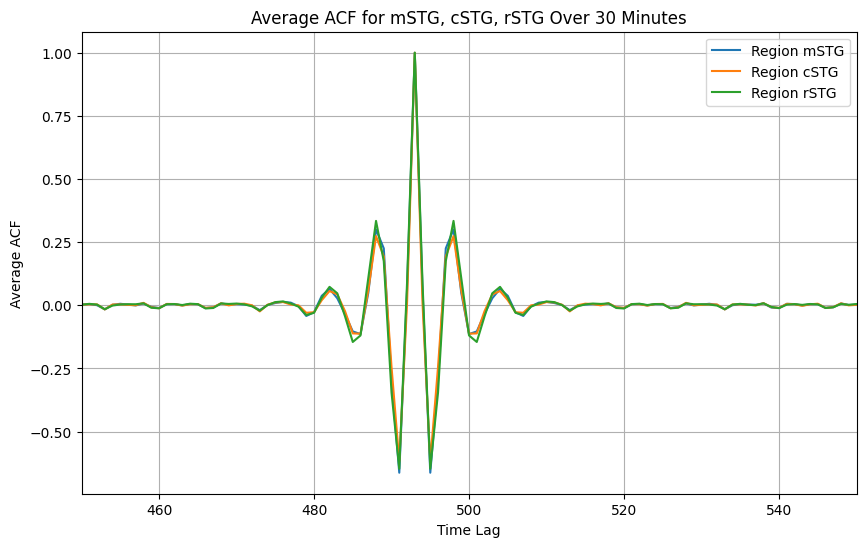

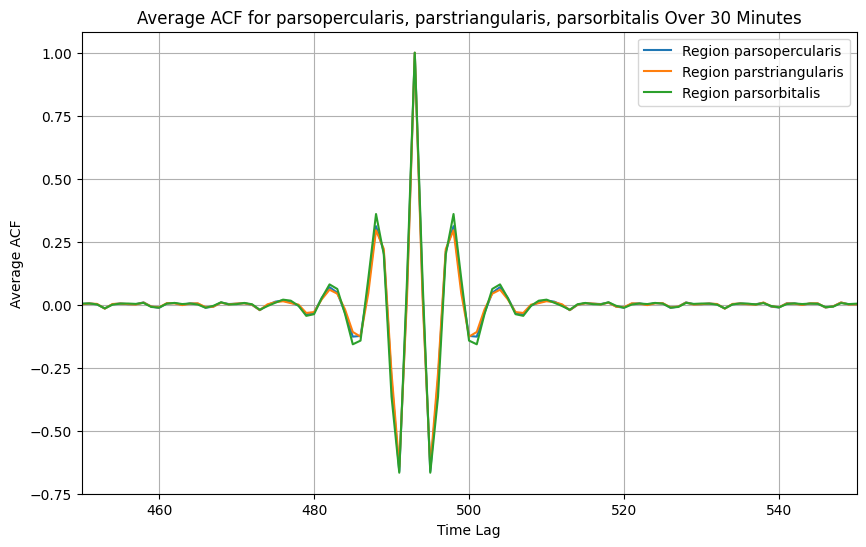

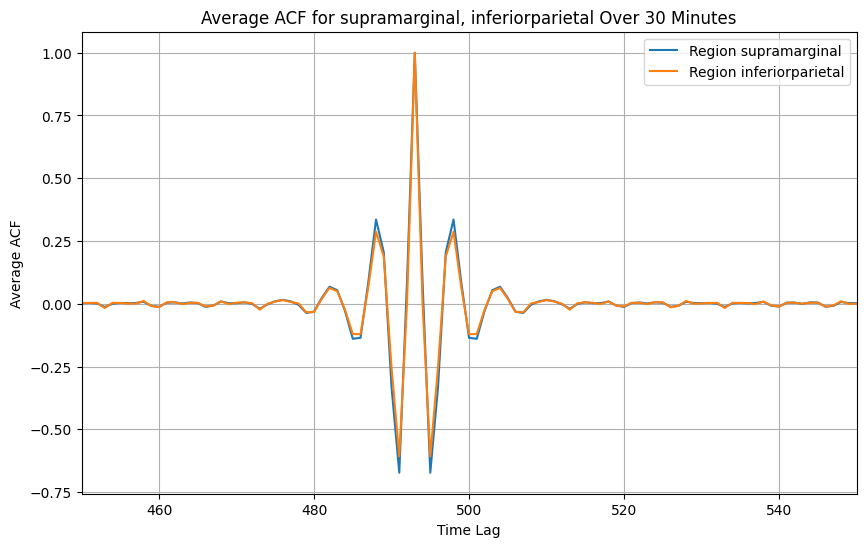

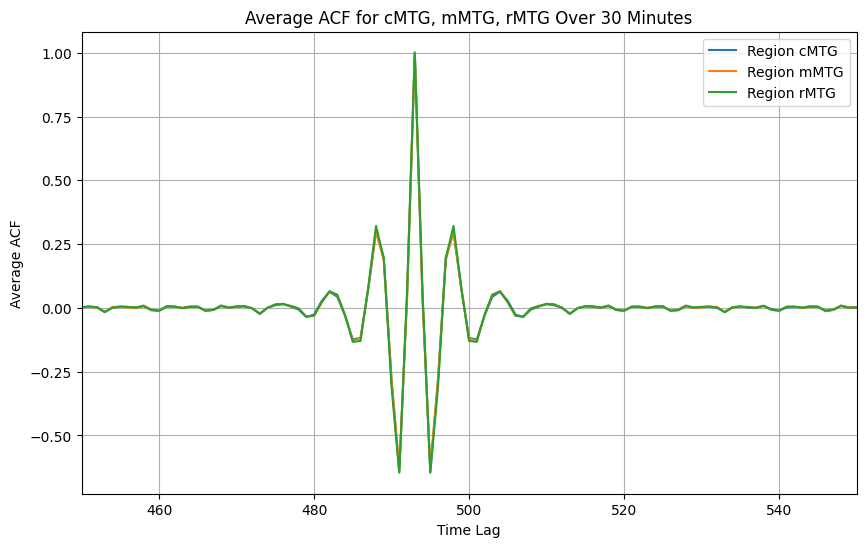

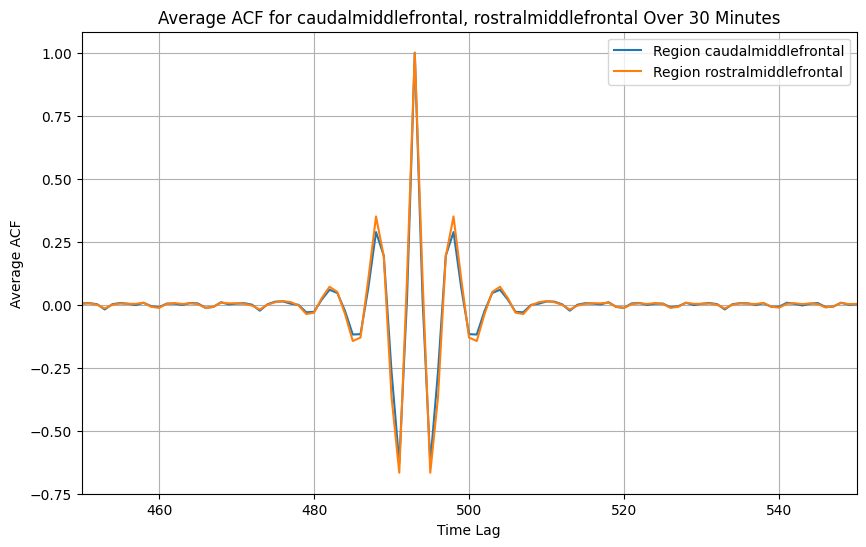

In [602]:
# Define the regions of interest (ROIs) for each plot
rois_list = [
    (['mSTG', 'cSTG', 'rSTG'], 'Average ACF for mSTG, cSTG, rSTG Over 30 Minutes'),
    (['parsopercularis', 'parstriangularis', 'parsorbitalis'], 'Average ACF for parsopercularis, parstriangularis, parsorbitalis Over 30 Minutes'),
    (['supramarginal', 'inferiorparietal'], 'Average ACF for supramarginal, inferiorparietal Over 30 Minutes'),
    (['cMTG', 'mMTG', 'rMTG'], 'Average ACF for cMTG, mMTG, rMTG Over 30 Minutes'),
    (['caudalmiddlefrontal', 'rostralmiddlefrontal'], 'Average ACF for caudalmiddlefrontal, rostralmiddlefrontal Over 30 Minutes')
]
acf_dicts = [first_average_acf_lines,second_average_acf_lines,third_average_acf_lines]
# Plot the average ACF lines for each set of ROIs in each of three dictionary chunks
for rois, title in rois_list:
    plot_acf_for_rois(acf_dicts, rois, title)

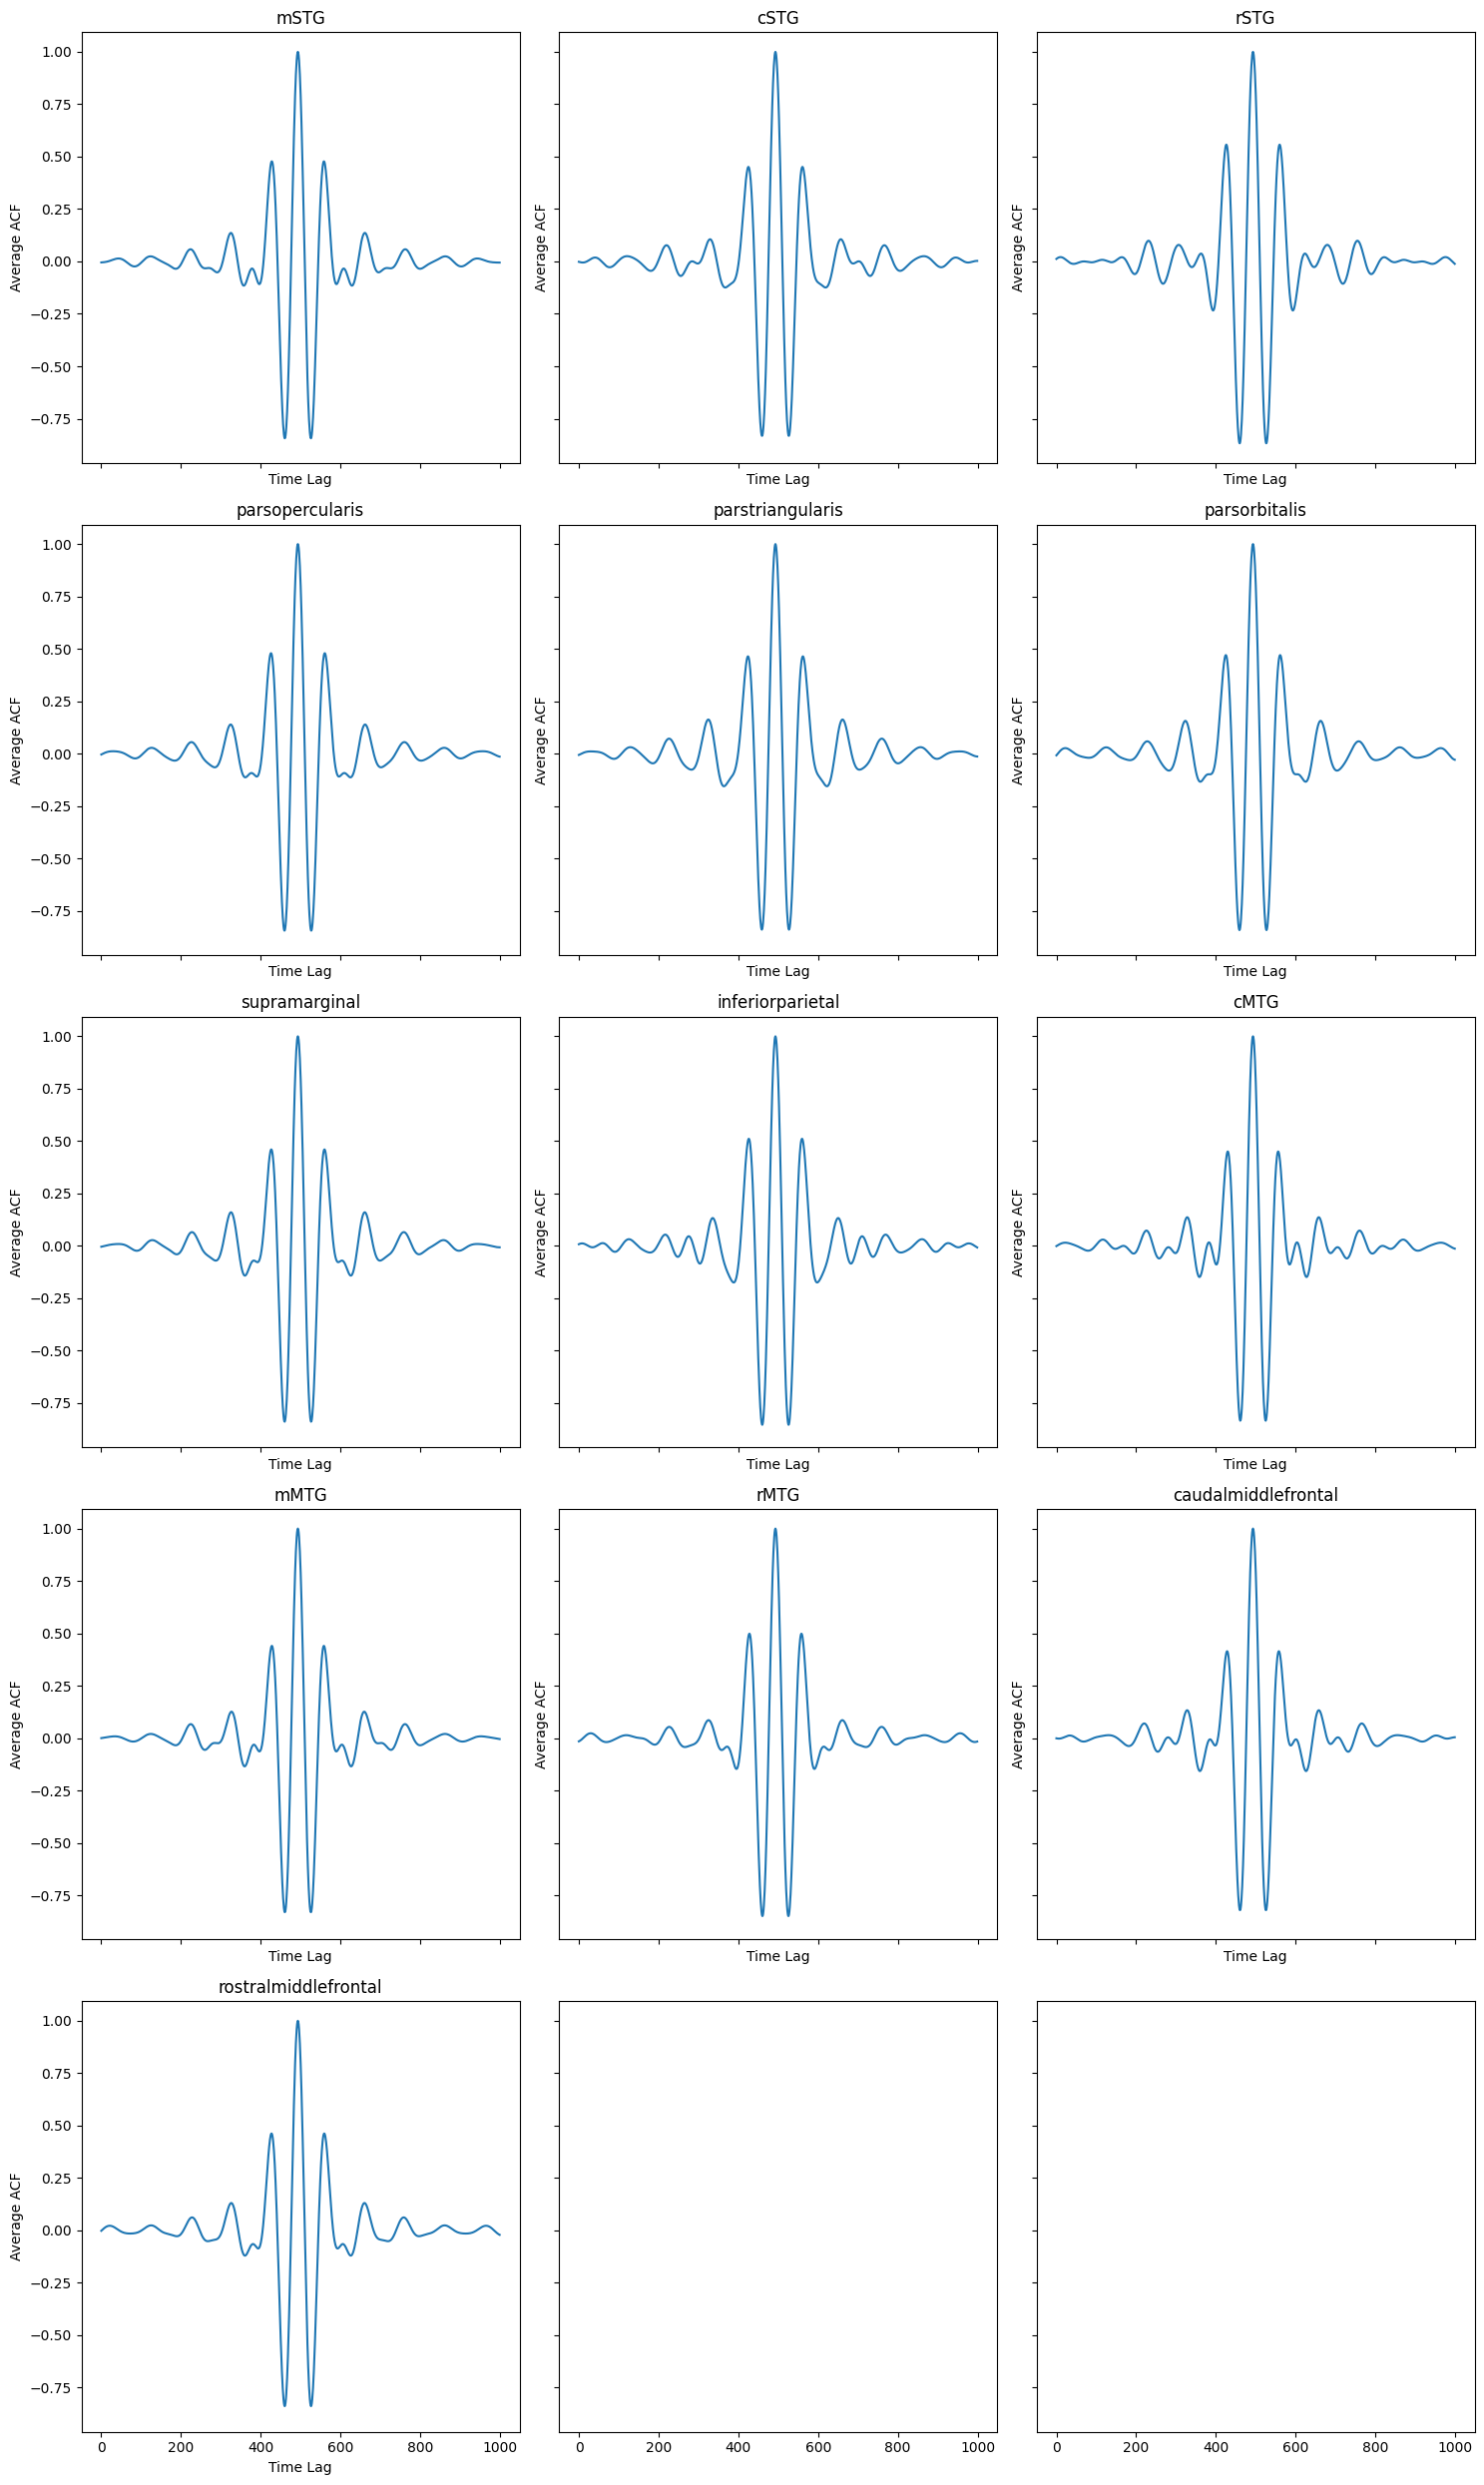

In [543]:
# List of regions of interest
regions_of_interest = ['mSTG', 'cSTG', 'rSTG', 'parsopercularis', 'parstriangularis', 
                       'parsorbitalis', 'supramarginal', 'inferiorparietal', 'cMTG', 
                       'mMTG', 'rMTG', 'caudalmiddlefrontal', 'rostralmiddlefrontal']

# Grouping the DataFrame by 'region'
grouped_df = acf_line_df.groupby('region')

# Initialize a dictionary to hold the average ACF lines for each region
average_acf_lines = {}

# Loop through each group, stack and average the specified columns
for region, group in grouped_df:
    if region in regions_of_interest:
        # Select columns 12 through the end
        selected_columns = group.iloc[:, 12:]
        
        # Stack and average the values
        electrode_average_acf = np.stack(selected_columns.values).mean(axis=0)
        
        # Store the average line for the region
        average_acf_lines[region] = electrode_average_acf

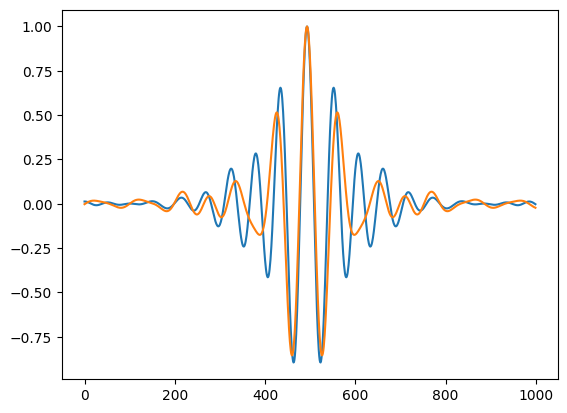

In [486]:
plt.plot(np.stack(first_corr_results[0]).mean(0))
plt.plot(np.stack(first_corr_results[20]).mean(0))

## Create 3 New Columns to Dataframe of the ACW Averages Per Chunk

In [239]:
# Add new columns to df_sorted
df_sorted['ACW_first_chunk'] = first_ACW_avgs
df_sorted['ACW_second_chunk'] = second_ACW_avgs
df_sorted['ACW_third_chunk'] = third_ACW_avgs
df_sorted.head()

,subject_number,electrode_name,x,y,z,region,subject_electrode,elec,ACW_first_chunk,ACW_second_chunk,ACW_third_chunk
29,662,EEGPO_02REF,-62.0,-58.000000,0.500000,mMTG,NY662_111_Part1_conversation1_EEGPO_02REF,2,1.268338,1.374682,1.386394
31,717,LGA47,-74.0,-25.000000,-3.000000,mMTG,NY717_111_Part1_conversation1_LGA47,47,1.218432,1.244757,1.238424
32,717,LGB119,-72.0,-8.666667,-5.333333,mMTG,NY717_111_Part1_conversation1_LGB119,119,1.285764,1.296811,1.291456
33,717,LGB126,-74.0,-20.000000,-5.000000,mMTG,NY717_111_Part1_conversation1_LGB126,126,1.265563,1.283214,1.280487
136,717,LGB71,-58.0,36.000000,21.000000,rostralmiddlefrontal,NY717_111_Part1_conversation1_LGB71,71,1.298568,1.291006,1.296150


## Plot Node Locations and Average ACW Values Using NiLearn

In [240]:
node_coordinates = df_sorted[['x','y','z']].values # node coords in space for plotting in nilearn

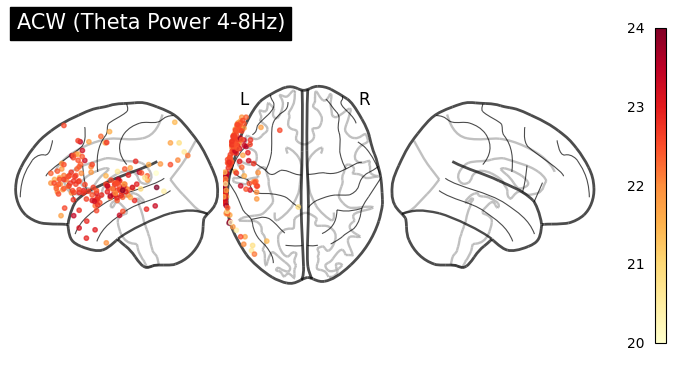

In [409]:
# fig, ax = plt.subplots(3, 1, figsize=(20, 9), dpi=400)
plotting.plot_markers(
    node_values=first_ACW_avgs, 
    node_coords = node_coordinates,
    node_cmap=cm.YlOrRd,
    node_size=10,
    title = 'ACW (Theta Power 4-8Hz)',
    colorbar=True,
    display_mode='lzr',
    # output_file = 'avg_acw_location_visual.svg'
    # axes=ax[0]
)
# plotting.plot_markers(
#     node_values=second_ACW_avgs, 
#     node_coords = node_coordinates,
#     node_cmap=cm.YlOrRd,
#     node_size=10,
#     axes=ax[1]
# )
# plotting.plot_markers(
#     node_values=third_ACW_avgs, 
#     node_coords = node_coordinates,
#     node_cmap=cm.YlOrRd,
#     node_size=10,
#     axes=ax[2]
# )
# ax.text(0.5, 0.1, 'First Chunk', ha='center', va='center', transform=ax.transAxes, fontsize=12)
# ax[1].text(0.5, 0.1, 'Middle Chunk', ha='center', va='center', transform=ax[1].transAxes, fontsize=12)
# ax[2].text(0.5, 0.1, 'Last Chunk', ha='center', va='center', transform=ax[2].transAxes, fontsize=12)
plt.savefig('theta_power_acw.svg')
plt.show()

## Create Standalone Colorbar

In [290]:
import matplotlib as mpl

In [327]:
def standalone_colorbar(
    cmap: str,
    ticks=(0, 1),
    tick_labels=(0, 1),
    figsize=(1, 1.5),
    dpi: int = 600,
):
    """Adapted from https://stackoverflow.com/a/62436015"""

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # left, bottom, width, height, fractions of figure width and height
    ax = fig.add_axes([0.05, 0.80,0.1, 0.9])
    cbar = mpl.colorbar.ColorbarBase(ax, orientation="vertical", cmap=cmap)
    cbar.ax.set_yticks(ticks)
    cbar.ax.set_yticklabels(tick_labels)

    return fig

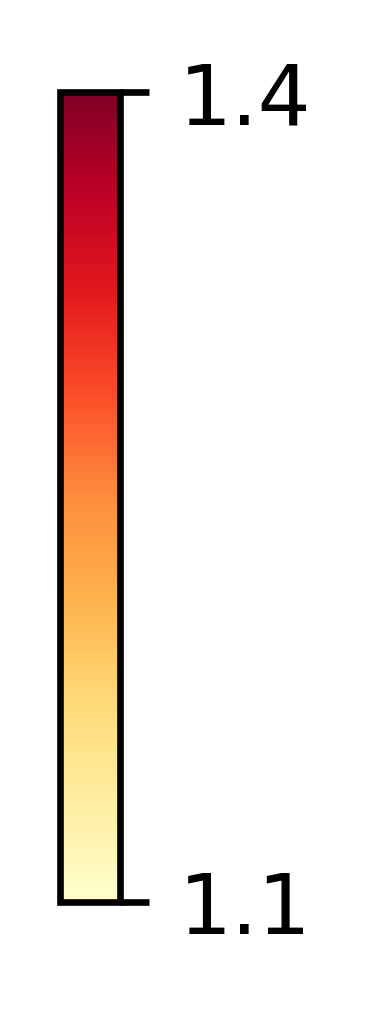

In [329]:
fig = standalone_colorbar(
    cmap = 'YlOrRd',
    tick_labels=(1.1,1.4)
)
# fig.savefig('colorbar2.svg')
plt.show()

## Plot of Top Six Brain Regions and their Average ACWs per Chunk

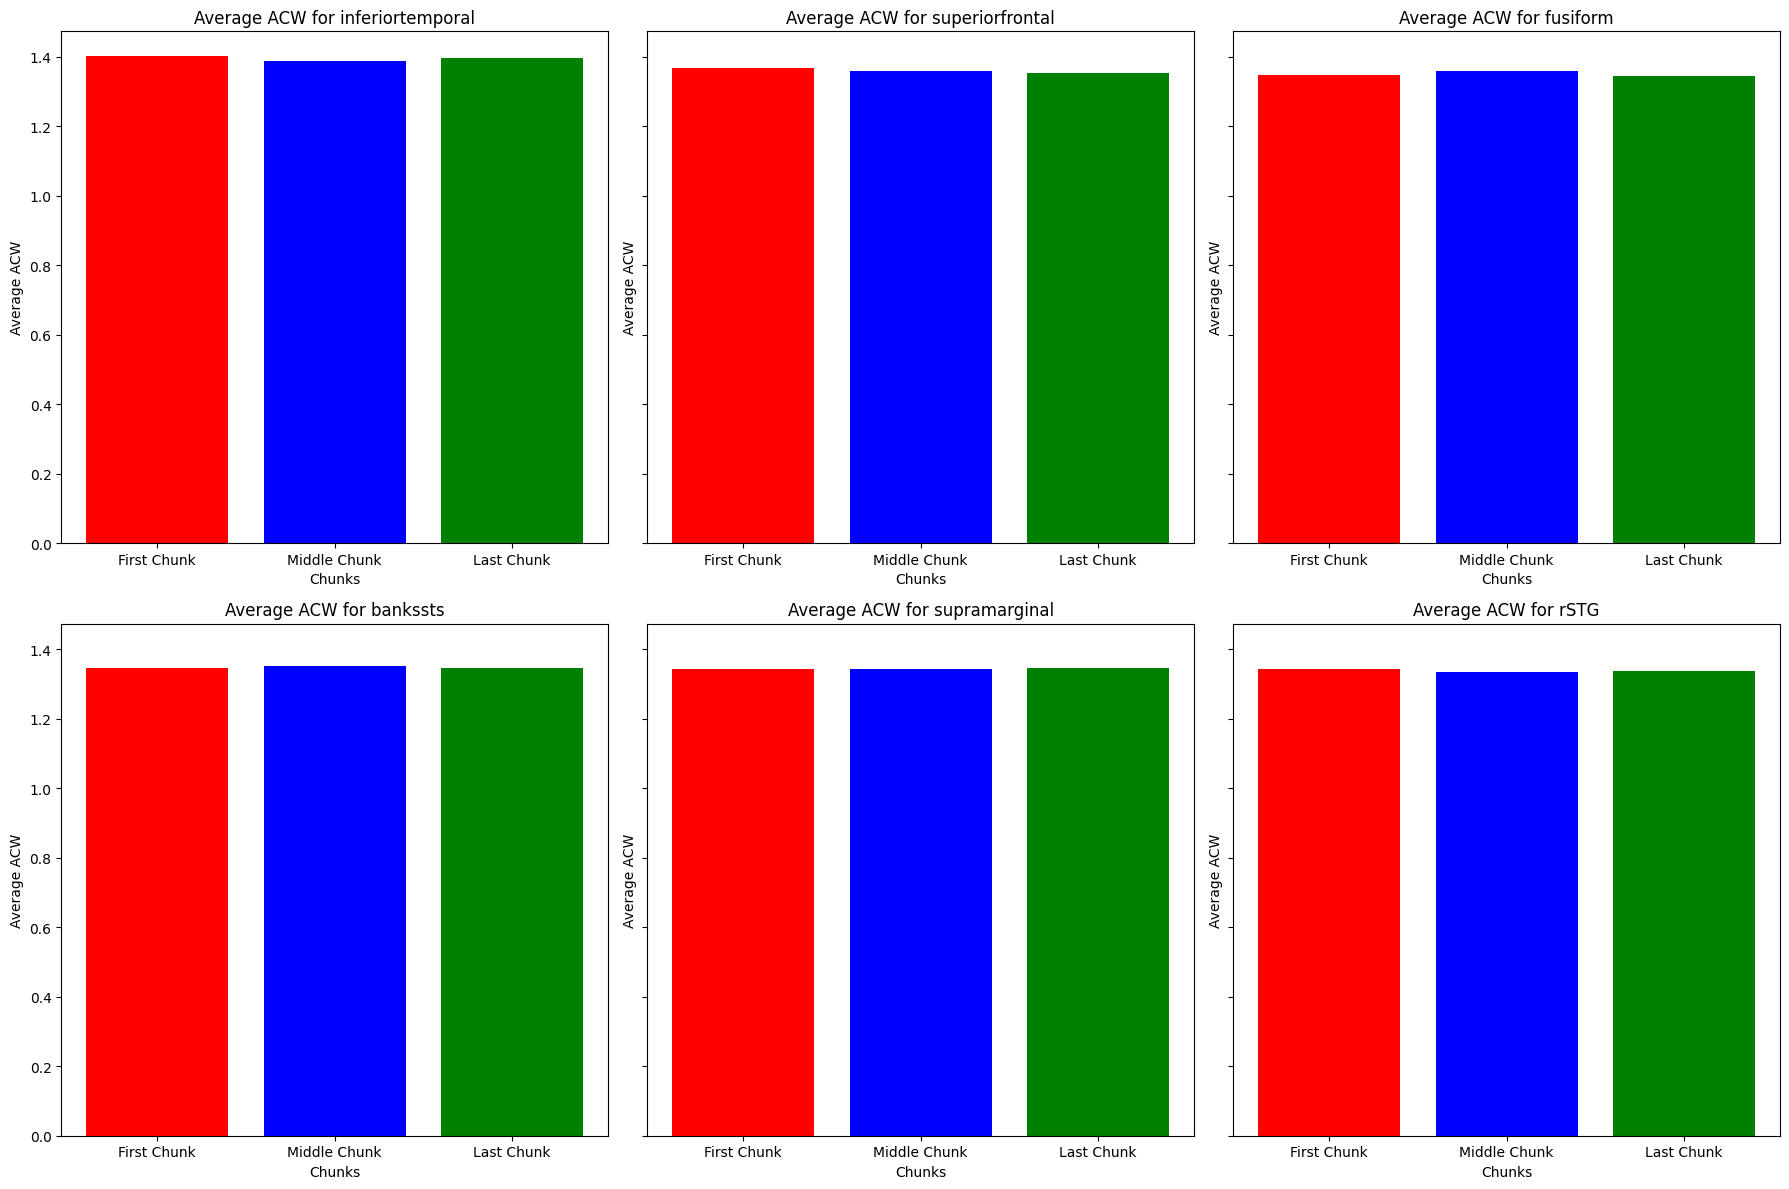

In [278]:
# Calculate the combined average ACW for each region
df_sorted['ACW_combined'] = df_sorted[['ACW_first_chunk', 'ACW_second_chunk', 'ACW_third_chunk']].mean(axis=1)

# Group by region and calculate the mean ACW for each chunk
grouped_df = df_sorted.groupby('region').agg({
    'ACW_first_chunk': 'mean',
    'ACW_second_chunk': 'mean',
    'ACW_third_chunk': 'mean',
    'ACW_combined': 'mean'
}).reset_index()
# Plotting
num_regions = grouped_df.shape[0]

# Select the top 6 regions based on the combined average ACW
top_6_regions = grouped_df.nlargest(6, 'ACW_combined')
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
axes = axes.flatten()

for i, region in enumerate(top_6_regions['region']):
    region_data = top_6_regions[top_6_regions['region'] == region]
    acw_values = [region_data['ACW_first_chunk'].values[0],
                  region_data['ACW_second_chunk'].values[0],
                  region_data['ACW_third_chunk'].values[0]]
    axes[i].bar(['First Chunk', 'Middle Chunk', 'Last Chunk'], acw_values, color=['red', 'blue', 'green'])
    axes[i].set_title(f'Average ACW for {region}')
    axes[i].set_xlabel('Chunks')
    axes[i].set_ylabel('Average ACW')

plt.tight_layout()
plt.savefig('avg_acw_regions.svg')
plt.show()

In [537]:
df_sorted['region'].sort_values().unique()

array(['Left-Cerebral-White-Matter', 'Unknown', 'bankssts', 'cMTG',
       'cSTG', 'caudalmiddlefrontal', 'fusiform', 'inferiorparietal',
       'inferiortemporal', 'isthmuscingulate', 'lateralorbitofrontal',
       'mMTG', 'mSTG', 'middletemporal_div2', 'parsopercularis',
       'parsorbitalis', 'parstriangularis', 'postcentral', 'precentral',
       'r', 'rMTG', 'rSTG', 'rostralmiddlefrontal', 'superiorfrontal',
       'superiortemporal_div1', 'superiortemporal_div2', 'supramarginal'],
      dtype=object)

In [254]:
num_regions

27

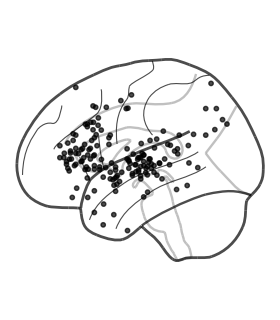

In [614]:
plotting.plot_markers(
    node_values=first_ACW_avgs, 
    node_coords = node_coordinates,
    node_cmap='Grays',
    node_size=10,
    node_vmin=0.9,
    node_vmax=0.9,
    # title = 'ACW (Theta Power 4-8Hz)',
    colorbar=False,
    display_mode='l'
)
plt.savefig('electrode-placement.svg')
plt.show()

/var/folders/_7/61vbt98120v7tjjx9b62g2ph0000gn/T/ipykernel_29135/3914870006.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


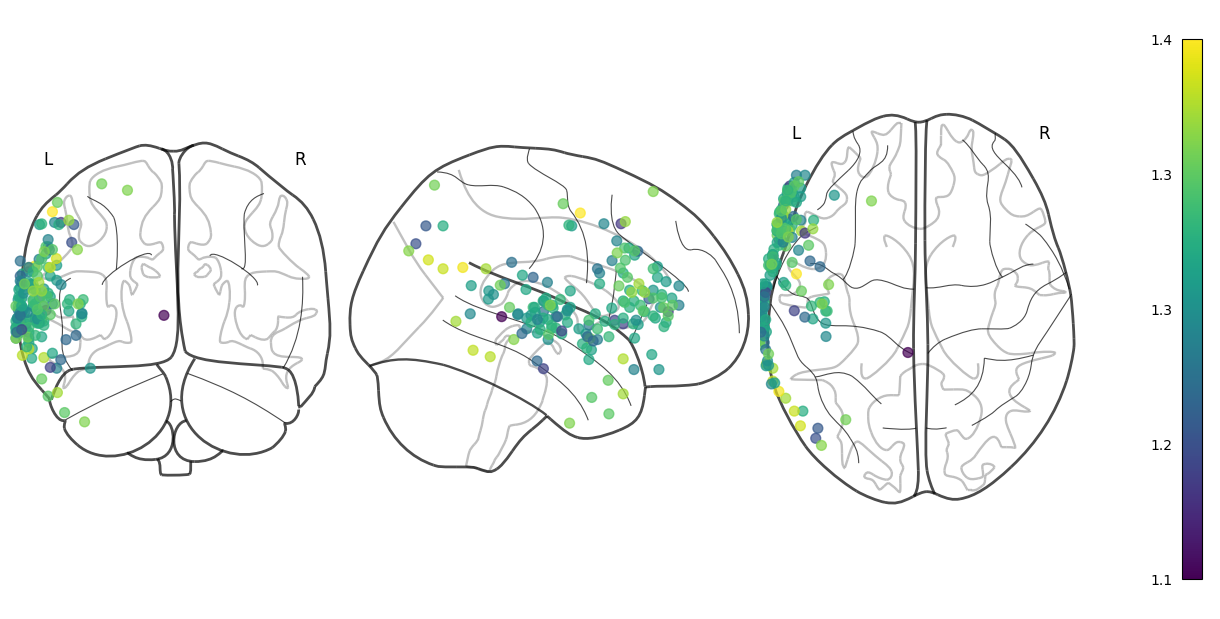

In [230]:
second_chunk_acw = ACW_second.mean(-1)

fig = plot_values(raw, second_chunk_acw, cmap='viridis', mode='ortho')
fig.show()

In [279]:
# !ls -l /Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY717_111_Part1_conversation1/raw